# Otimização de viga com o Pyomo

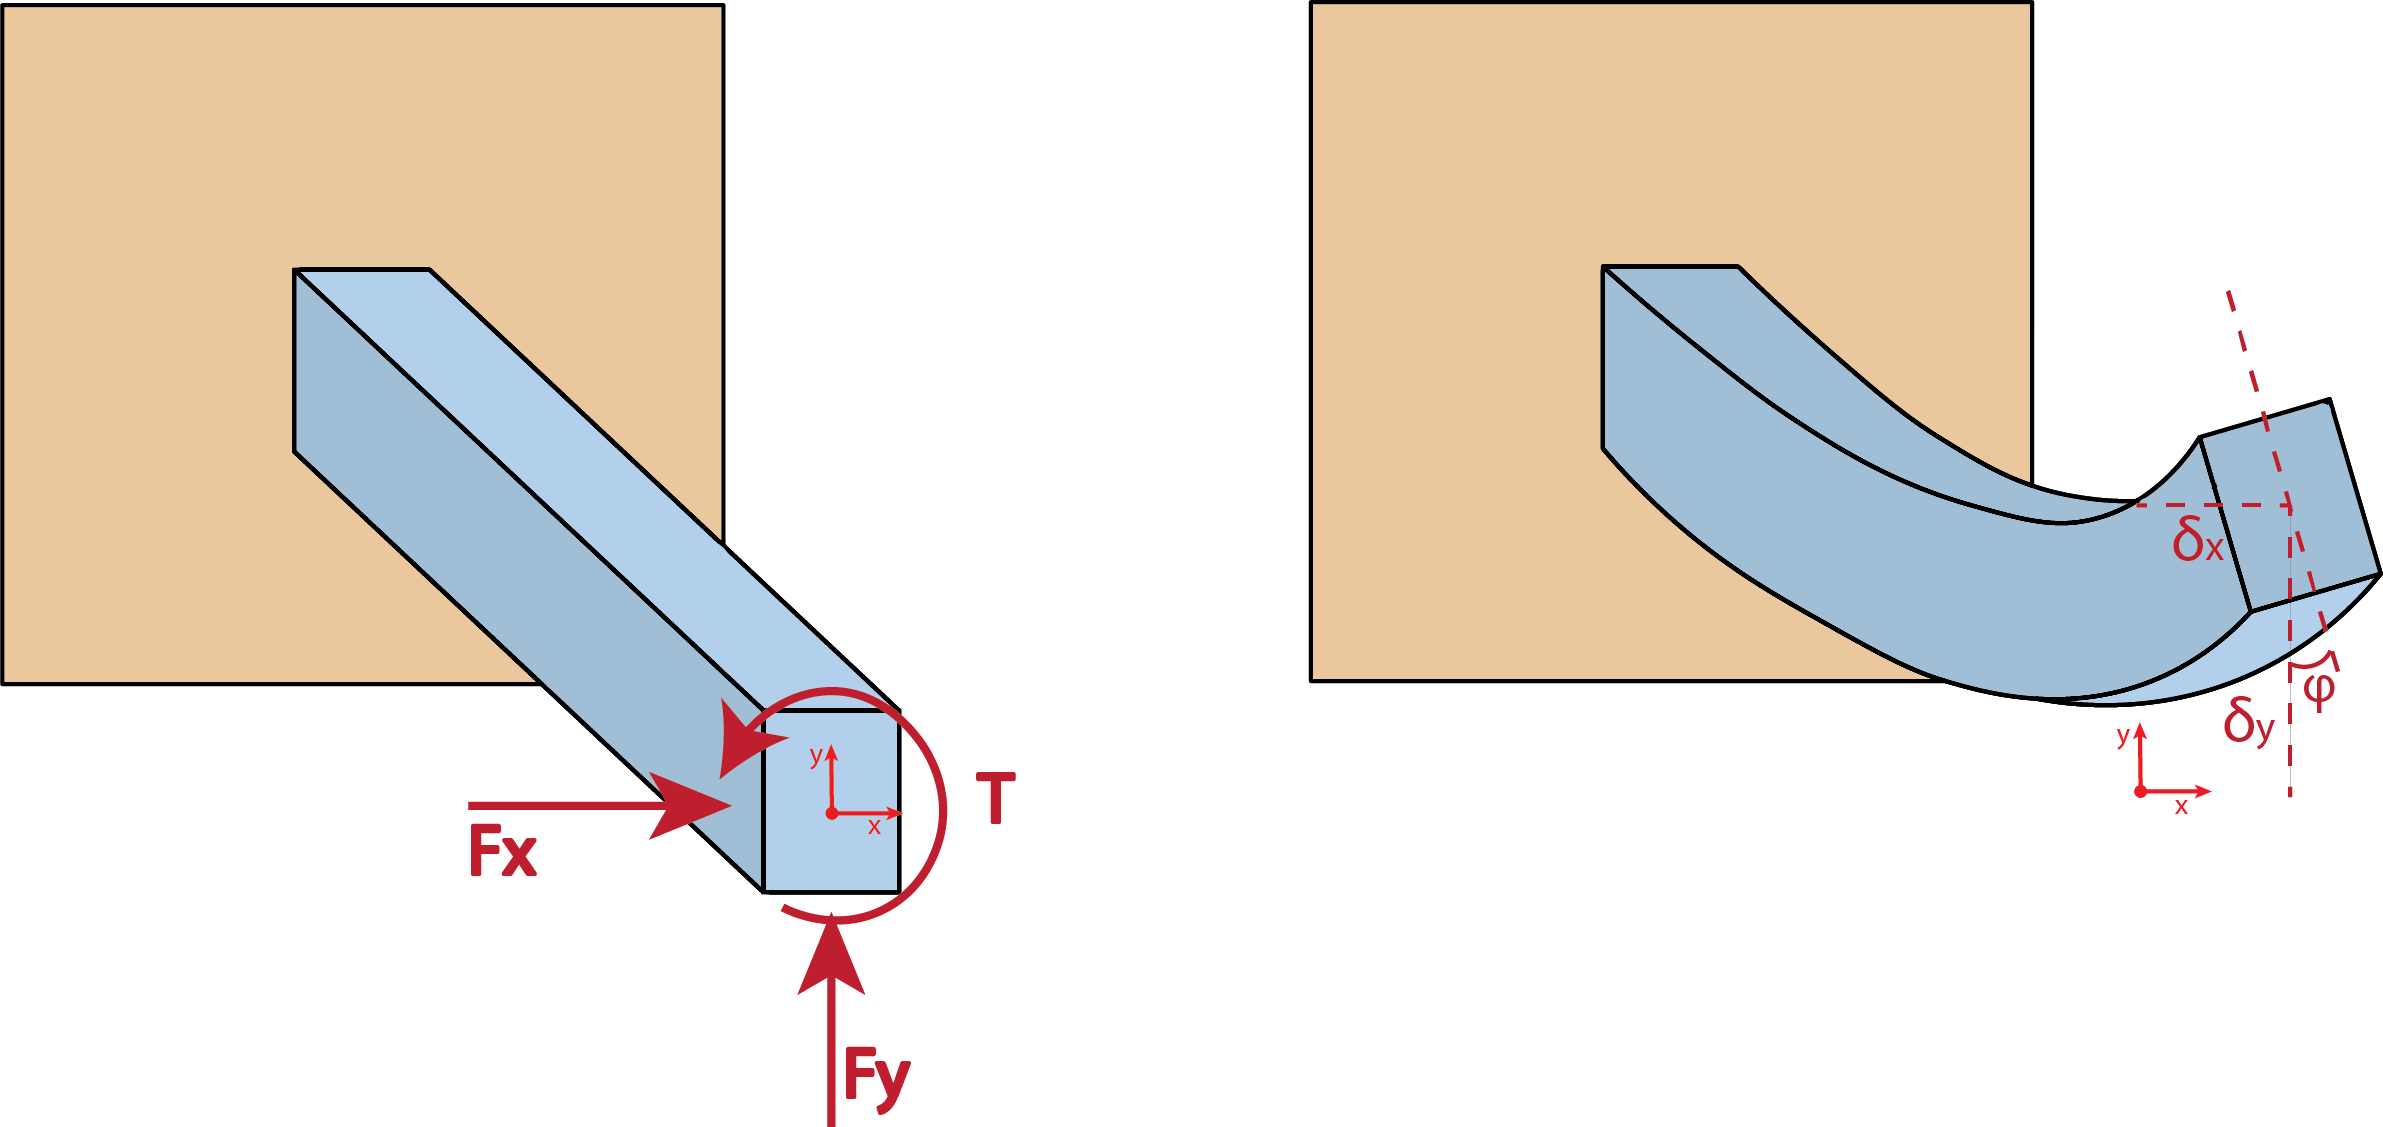

## Carregamento

A viga deve cumprir os requisitos para o seguinte caso de carga

| Carga | Valor |
| -- | -- |
| Fy [N] | 1000 | 
| Fx [N] | 800 |
| T  [Nm] | 900 |

In [1]:
Fy = 1E3 # N
Fx = 800 # N
T = 900 # Nm

## Propriedades do aço

In [5]:
L = 2 # m
rho = 8000 # kg/m3
E = 200E9 # Pa
v = 0.3 # -
G = E/((1+v)*2) # Pa

## Equação de flecha e ângulo de torção da uma viga

$\delta = \frac{PL^3}{3EI}$

$\phi = \frac{TL}{JG}$

$massa = whL\rho$

In [2]:
# var = [w,h]

def massa_f(var):
    w = var[0]
    h = var[1]
    massa = w*h*L*rho
    return massa

def dy_f(var):   
    delta = Fy*L**3/(3*E*I_f(var)) 
    return delta

def dx_f(var):   
    delta = Fx*L**3/(3*E*I_f(var[::-1])) 
    return delta

def phi_f(var):       
    phi = (T*L/(J_f(var)*G))*180/3.1416
    return phi

def I_f(var):
    w = var[0]
    h = var[1]
    I = w*h**3/12
    return I

def J_f(var):
    w = var[0]
    h = var[1]
    J = w*h**3/12 + h*w**3/12
    return J

# Modelagem Matemática

### Objetivo:

$minimizar(massa)$

### Variáveis:

$ w,h $

### Limite das variáveis:

$ 0.01 < w < 0.25 ; \hspace{1cm} 0.01<h<0.3$

### Condições de contorno:

$ \delta_x < 0.01m $

$ \delta_y < 0.03m $

$ \phi < 1° $

### Chute inicial: 

$ w_0 = 0.04m ; h_0 = 0.05m $

In [3]:
#import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory 

In [8]:
# Chute inicial
w_h_0 = [0.04,0.05] 

# Valores das condições de contorno 
dx_max = 0.01
dy_max = 0.03
phi_max = 1

# Modelo 
model = ConcreteModel()

# Variáveis no modelo
model.w = Var(bounds=(0.01,0.25), initialize = w_h_0[0])
model.h = Var(bounds=(0.01,0.3), initialize = w_h_0[1])

w = model.w
h = model.h

# CC no modelo 
model.C1 = Constraint(rule = dx_f([w,h])<=dx_max)
model.C2 = Constraint(rule = dy_f([w,h])<=dy_max)
model.C3 = Constraint(rule = phi_f([w,h])<=phi_max)

# Parâmetros com o chute inicial
print('Massa inicial [kg]: ', massa_f(w_h_0))
print('Delta x inicial [m]: ', dx_f(w_h_0))
print('Delta y inicial [m]: ', dy_f(w_h_0))
print('Phi inicial [°]: ', phi_f(w_h_0))

Massa inicial [kg]:  32.0
Delta x inicial [m]:  0.039999999999999994
Delta y inicial [m]:  0.031999999999999994
Phi inicial [°]:  1.9620264957424207


# Solução
### Definição do algarítimo

```Fonte: Engineering Design Optimization - Joaquin Martins```
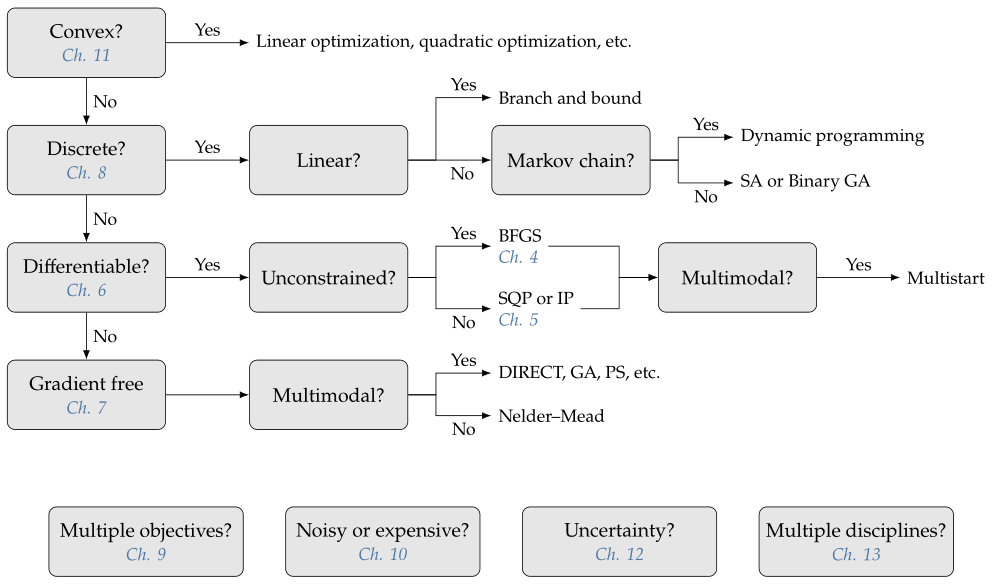

### IPOPT

**I**nterior **P**oint **Opt**imization (https://coin-or.github.io/Ipopt/)

In [9]:
model.obj = Objective(rule = massa_f([w,h]), sense=minimize)

opt = SolverFactory('ipopt',executable ='C:\\ipopt\\bin\\ipopt.exe')
opt.solve(model)

model.pprint()

w_value = value(w)
h_value = value(h)
print('============================================================')
print('Width [m]: ', w_value)
print('Height [m]: ', h_value)
print('Massa [kg]: ', massa_f([w_value,h_value]))

2 Var Declarations
    h : Size=1, Index=None
        Key  : Lower : Value                : Upper : Fixed : Stale : Domain
        None :  0.01 : 0.043074800724159146 :   0.3 : False : False :  Reals
    w : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  0.01 : 0.06673117209446394 :  0.25 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : w*h*2*8000

3 Constraint Declarations
    C1 : Size=1, Index=None, Active=True
        Key  : Lower : Body                              : Upper : Active
        None :  -Inf : 6400/(600000000000.0*(h*w**3/12)) :  0.01 :   True
    C2 : Size=1, Index=None, Active=True
        Key  : Lower : Body                                : Upper : Active
        None :  -Inf : 8000.0/(600000000000.0*(w*h**3/12)) :  0.03 :   True
    C3 : Size=1, Index=None, Active=True
        Key